#Data Analysist of Vaccine data provided by the CDC on March 25, 2021
The CSV file contains the number of Doses delivered and administered and all relevant data.
It is organized by state/territory/Entity

Author: Josue Gil

In [1]:


library(tidyverse)
library(dplyr)
library(scales)
library(ggthemes)
library(maps)
t <- read_csv("//Users/josue_gil/Desktop/V/Vaccinations.csv",skip =2)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  `State/Territory/Federal Entity` = col_character(),
  `Doses Delivered per 100K` = col_character(),
  `18+ Doses Delivered per 100K` = col_character(),
  `Doses Administered per 100k by State where Administered` = col_character(),
  `

#The stateselect() function takes a data frame of vaccine data and 
selects wanted varaibles, renames variables and removes rows that
are not wanted

In [2]:
stateselect <- function(n){#selecting the wanted variables of the vaccine data
  #Faster to rename the columns in the CSV file but used dplyr for practice.
  Vaccines <- n %>% select('State/Territory/Federal Entity', 'Total Doses Delivered','Total Doses Administered by State where Administered',
                           'Doses Administered per 100k by State where Administered','People with at least One Dose by State of Residence',
                           'Percent of Total Pop with at least One Dose by State of Residence','People Fully Vaccinated by State of Residence',
                           'Percent of Total Pop Fully Vaccinated by State of Residence')
  #Renaming the variables to shorter titles 
  Vaccines<- rename(Vaccines,State = 'State/Territory/Federal Entity',TotalD = 'Total Doses Delivered',
                    TotalA = 'Total Doses Administered by State where Administered', TotalAPer = 'Doses Administered per 100k by State where Administered',
                    OneDose = 'People with at least One Dose by State of Residence', P_OneDose='Percent of Total Pop with at least One Dose by State of Residence',
                    FullyVac = 'People Fully Vaccinated by State of Residence',P_FullyVac ='Percent of Total Pop Fully Vaccinated by State of Residence')
  Vaccines <- Vaccines  %>% mutate(P_FullyVac = as.numeric(P_FullyVac),P_OneDose = as.numeric(P_OneDose)) %>%
    filter(!is.na(P_OneDose), TotalA > 80000)
}

#Function that changes units to have K(thousands) or M (millions)

In [3]:
addUnits <- function(n) {
  labels <- ifelse(n < 1000, n,  # less than thousands
                   ifelse(n < 1e6, paste0(round(n/1e3), 'k'),  # in thousands
                          ifelse(n < 1e9, paste0(round(n/1e6), 'M'))))  # in millions
  return(labels)
}

#We get some warnings during stateselect() that can be ignore so we remove them

In [4]:
Vaccines <- suppressWarnings(stateselect(t))

#Bar graph of Administered Vaccines colored by the % of pop with at least one dose

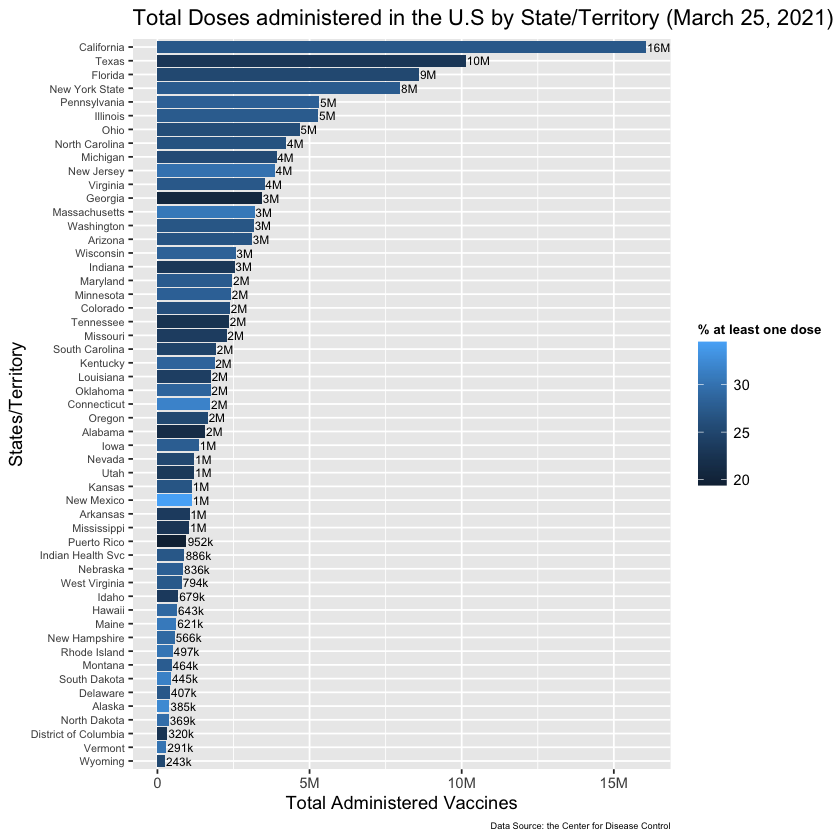

In [18]:
Vaccines %>% mutate(State = reorder(State, TotalA)) %>% 
  ggplot(aes(State,TotalA, fill = P_OneDose)) + geom_col() + 
  scale_y_continuous(name = "Total Administered Vaccines",labels = addUnits)+ 
  theme(axis.text.y = element_text(size = 6.5),legend.title = element_text(size = 8,face = "bold"),
        plot.caption = element_text(size = 5.5))+
  coord_flip()+ labs(title = "Total Doses administered in the U.S by State/Territory (March 25, 2021)",
       caption = "Data Source: The Center for Disease Control and Prevention", 
       x = "States/Territory", fill = "% at least one dose") +
  geom_text(aes(label = addUnits(TotalA)),size = 2.5, hjust = -0.05)

#Histogram of the percentages of people with one dose

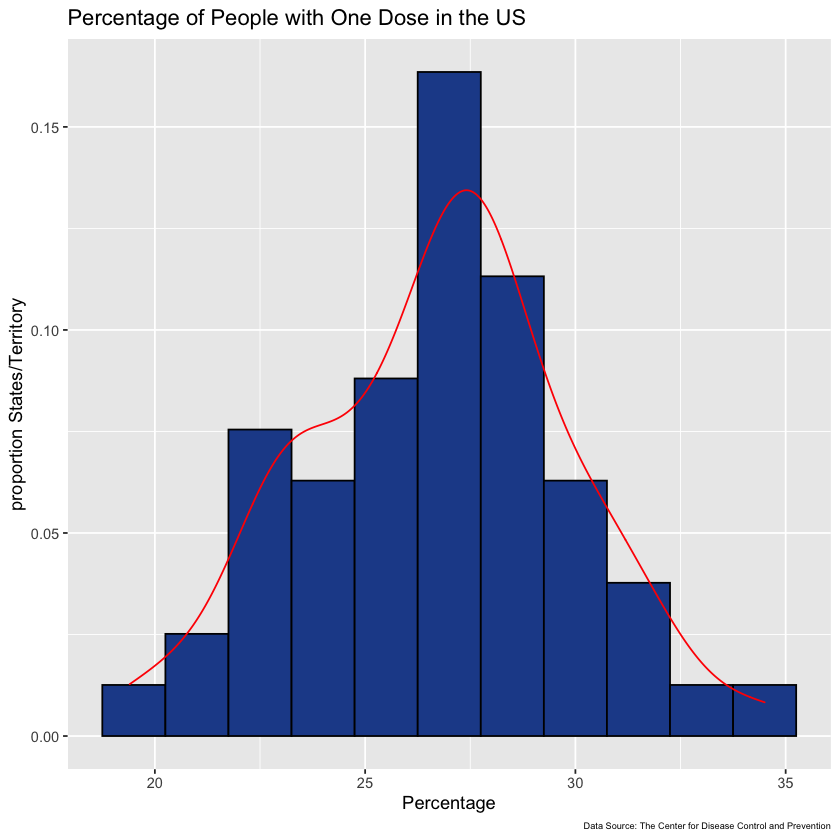

In [40]:
Vaccines %>% ggplot(aes(P_OneDose, y =..density..))  +
  geom_histogram(binwidth = 1.5, fill = "#224C98", color = "black")+ 
  geom_density(color = "red") + labs(y = "proportion States/Territory", x = "Percentage",
                                     title = "Percentage of People with One Dose in the US",
                                     caption = "Data Source: The Center for Disease Control and Prevention")+
theme(plot.caption = element_text(size = 5.5))


#Map of the US with percentage of people with one dose

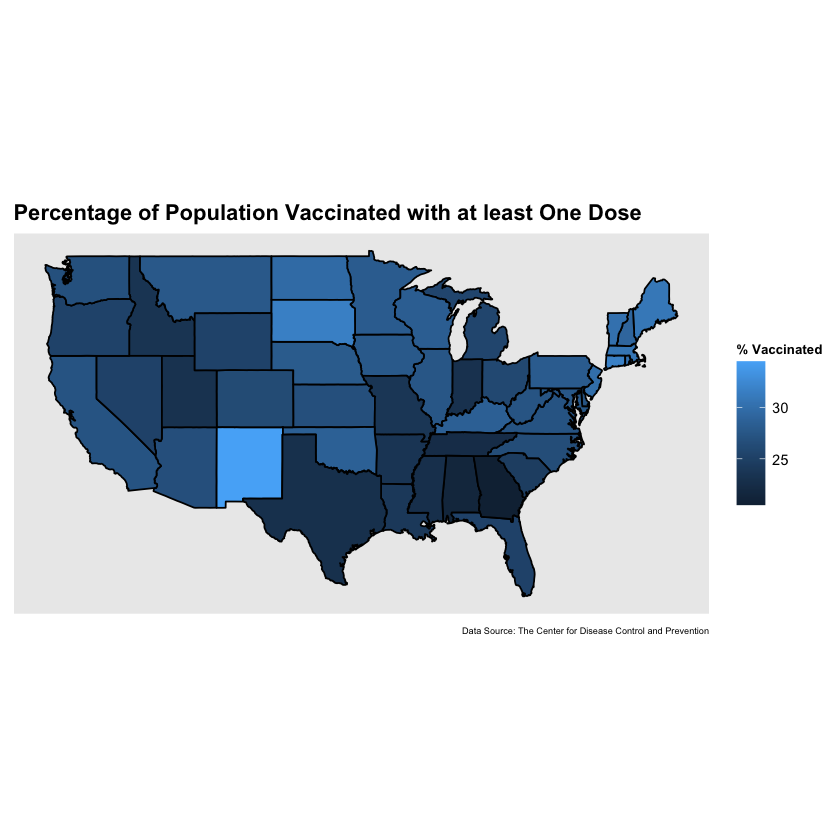

In [39]:
usmap <- map_data("state")%>% select(region,long,lat,group)
statesonly <- Vaccines %>% filter(!State %in% c("Puerto Rico","Indian Health Svc")) %>% 
  rename(region = State) %>% mutate(region = tolower(region))
vaccinemap <- inner_join(usmap, statesonly,by = "region")
vaccinemap %>% ggplot(aes(x=long,y=lat,fill= P_OneDose)) + 
  geom_polygon(aes(group = group), color = "black")+coord_fixed(1.3) + theme(
    axis.text = element_blank(),
    axis.line = element_blank(),
    axis.ticks = element_blank(),
    panel.border = element_blank(),
    panel.grid = element_blank(),
    axis.title = element_blank()) + labs(title = "Percentage of Population Vaccinated with at least One Dose",
                                        caption = "Data Source: The Center for Disease Control and Prevention",
                                        fill = "% Vaccinated")+ theme(legend.title = element_text(size = 8,face = "bold"),
        plot.caption = element_text(size = 5.5),plot.title = element_text(face = "bold"))
